In [2]:
# 代码1: extract_score_tokens.py - 提取并保存评分token信息

import numpy as np
import os
import json
import re
import pickle

# 文件夹路径
folder_path = "./llm_embedding/results/results"

def extract_score_token_index(generated_text, prompt_type):
    """
    从generated_text中提取评分token的索引
    返回: (token_index, score_value, extracted_token)
    """
    try:
        # 清理文本：移除markdown代码块标记和多余的空白
        cleaned_text = generated_text.strip()
        
        # 移除```json和```标记
        cleaned_text = re.sub(r'```json\s*', '', cleaned_text)
        cleaned_text = re.sub(r'```\s*', '', cleaned_text)
        
        # 尝试查找JSON对象
        # 匹配{...}格式的JSON
        json_pattern = r'\{[^}]*\}'
        json_matches = re.findall(json_pattern, cleaned_text, re.DOTALL)
        
        if not json_matches:
            print(f"Warning: No JSON object found in text: {generated_text[:100]}...")
            return None, None, None
        
        # 尝试解析找到的JSON对象
        data = None
        for json_str in json_matches:
            try:
                data = json.loads(json_str)
                if data:
                    break
            except json.JSONDecodeError:
                continue
        
        if data is None:
            print(f"Warning: Could not parse any JSON in text: {generated_text[:100]}...")
            return None, None, None
        
        if prompt_type == 'punishment':
            score_key = 'punishment_score'
        else:  # emotion
            score_key = 'emotional_score'
        
        score_value = data.get(score_key, None)
        
        if score_value is None:
            print(f"Warning: Score key '{score_key}' not found in JSON: {data}")
            return None, None, None
        
        # 在原始generated_text中查找评分数字的位置
        # 匹配模式: "punishment_score": 9 或 "emotional_score": 9
        pattern = f'"{score_key}":\\s*(\\d+)'
        match = re.search(pattern, generated_text)
        
        if match:
            # 找到最后一个包含score_key的JSON对象的位置
            # 在generated_text中定位到JSON开始的位置
            json_start_pattern = r'\{[^}]*"' + score_key + r'":\s*\d+[^}]*\}'
            json_start_match = re.search(json_start_pattern, generated_text)
            
            if json_start_match:
                # 对于JSON格式 {"punishment_score": 9} 或 {"emotional_score": 9}
                # token序列大致是: {, "key", :, 9, }
                # 数字token的索引通常是第3个token (索引为3)
                token_index = 3
            else:
                token_index = 3  # 默认值
            
            return token_index, score_value, str(score_value)
        else:
            print(f"Warning: Could not find score pattern in text: {generated_text[:100]}...")
            return None, None, None
            
    except Exception as e:
        print(f"Error parsing generated_text: {e}")
        print(f"Text: {generated_text[:200]}...")
        return None, None, None

# 存储所有文件的token信息
all_token_info = {}

print("=" * 80)
print("开始提取评分token信息...")
print("=" * 80)

# 遍历所有文件
file_count = 0
success_count = 0
failed_count = 0

for i in range(1, 217):
    for prompt_type in ['punishment', 'emotion']:
        file_name = f"prompt_{i:03d}_{prompt_type}.npz"
        file_path = os.path.join(folder_path, file_name)
        
        if os.path.exists(file_path):
            file_count += 1
            try:
                # 读取npz文件
                data = np.load(file_path, allow_pickle=True)
                
                # 解析meta信息
                meta_str = str(data['meta'])
                meta_dict = json.loads(meta_str)
                generated_texts = meta_dict.get('generated_texts', [])
                generated_text_combined = ''.join(generated_texts)
                
                # 获取output_hidden的shape
                output_hidden_shape = data['output_hidden'].shape
                
                # 提取评分token的索引
                token_index, score_value, extracted_token = extract_score_token_index(
                    generated_text_combined, prompt_type
                )
                
                if token_index is not None and score_value is not None:
                    success_count += 1
                else:
                    failed_count += 1
                    print(f"\n处理失败: {file_name}")
                    print(f"生成的文本: {generated_text_combined[:200]}...")
                
                # 存储信息
                all_token_info[file_name] = {
                    'prompt_type': prompt_type,
                    'generated_text': generated_text_combined,
                    'token_index': token_index,
                    'score_value': score_value,
                    'extracted_token': extracted_token,
                    'output_hidden_shape': output_hidden_shape,
                    'prompt_id': i
                }
                
                data.close()
                
            except Exception as e:
                print(f"\n读取文件 {file_name} 时出错: {str(e)}")
                failed_count += 1

print(f"\n处理完成:")
print(f"  总文件数: {file_count}")
print(f"  成功提取: {success_count}")
print(f"  失败数量: {failed_count}")

# 打印验证结果
print("\n" + "=" * 80)
print("提取的评分验证:")
print("=" * 80)

punishment_scores = []
emotion_scores = []

for i in range(1, 217):
    p_file = f"prompt_{i:03d}_punishment.npz"
    e_file = f"prompt_{i:03d}_emotion.npz"
    
    if p_file in all_token_info and all_token_info[p_file]['score_value'] is not None:
        punishment_scores.append(all_token_info[p_file]['score_value'])
    
    if e_file in all_token_info and all_token_info[e_file]['score_value'] is not None:
        emotion_scores.append(all_token_info[e_file]['score_value'])

print("\nPunishment评分:")
print(punishment_scores)
print(f"总数: {len(punishment_scores)}")
print(f"有效评分数: {sum(1 for s in punishment_scores if s is not None)}")

print("\nEmotion评分:")
print(emotion_scores)
print(f"总数: {len(emotion_scores)}")
print(f"有效评分数: {sum(1 for s in emotion_scores if s is not None)}")

print("\n所有评分（按文件顺序）:")
all_scores = []
none_count = 0
zero_count = 0
for i in range(1, 217):
    for prompt_type in ['punishment', 'emotion']:
        file_name = f"prompt_{i:03d}_{prompt_type}.npz"
        if file_name in all_token_info:
            score = all_token_info[file_name]['score_value']
            all_scores.append(score)
            if score is None:
                none_count += 1
            elif score == 0:
                zero_count += 1
                
print(all_scores)
print(f"总数: {len(all_scores)}")
print(f"None的数量: {none_count}")
print(f"0分的数量: {zero_count}")
print(f"有效评分数: {len(all_scores) - none_count}")

# 保存token信息到文件
output_file = 'score_token_info.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(all_token_info, f)

print("\n" + "=" * 80)
print(f"Token信息已保存到 '{output_file}'")
print("=" * 80)

# 同时保存为JSON格式（方便人工查看）
json_output_file = 'score_token_info.json'
# 将numpy类型转换为Python原生类型
json_friendly_info = {}
for key, value in all_token_info.items():
    json_friendly_info[key] = {
        'prompt_type': value['prompt_type'],
        'generated_text': value['generated_text'],
        'token_index': int(value['token_index']) if value['token_index'] is not None else None,
        'score_value': int(value['score_value']) if value['score_value'] is not None else None,
        'extracted_token': value['extracted_token'],
        'output_hidden_shape': [int(x) for x in value['output_hidden_shape']],
        'prompt_id': int(value['prompt_id'])
    }

with open(json_output_file, 'w', encoding='utf-8') as f:
    json.dump(json_friendly_info, f, indent=2, ensure_ascii=False)

print(f"Token信息（JSON格式）已保存到 '{json_output_file}'")
print("=" * 80)

# 打印一些失败案例供调试
print("\n失败案例示例（前5个）:")
failed_cases = [(k, v) for k, v in all_token_info.items() if v['score_value'] is None]
for i, (file_name, info) in enumerate(failed_cases[:5]):
    print(f"\n失败案例 {i+1}: {file_name}")
    print(f"生成文本: {info['generated_text'][:300]}...")

# 输出所有评分为0的文件的完整内容
print("\n" + "=" * 80)
print("评分为 0 的文件完整输出:")
print("=" * 80)

zero_score_cases = [(k, v) for k, v in all_token_info.items() if v['score_value'] == 0]

if zero_score_cases:
    print(f"\n找到 {len(zero_score_cases)} 个评分为0的文件\n")
    
    # 同时将评分为0的文件详细信息保存到单独的文件
    zero_score_output_file = 'zero_score_cases.txt'
    with open(zero_score_output_file, 'w', encoding='utf-8') as f:
        for i, (file_name, info) in enumerate(zero_score_cases):
            separator = "=" * 100
            output_text = f"\n{separator}\n"
            output_text += f"评分为0的案例 #{i+1}\n"
            output_text += f"{separator}\n"
            output_text += f"文件名: {file_name}\n"
            output_text += f"Prompt ID: {info['prompt_id']}\n"
            output_text += f"Prompt类型: {info['prompt_type']}\n"
            output_text += f"评分值: {info['score_value']}\n"
            output_text += f"Token索引: {info['token_index']}\n"
            output_text += f"Output Hidden Shape: {info['output_hidden_shape']}\n"
            output_text += f"\n完整生成文本:\n"
            output_text += "-" * 100 + "\n"
            output_text += info['generated_text']
            output_text += "\n" + "-" * 100 + "\n"
            
            # 打印到控制台
            print(output_text)
            
            # 写入文件
            f.write(output_text)
    
    print(f"\n所有评分为0的案例已保存到 '{zero_score_output_file}'")
else:
    print("\n没有找到评分为0的文件")

print("\n" + "=" * 80)
print("分析完成!")
print("=" * 80)

# 输出统计摘要
print("\n统计摘要:")
print(f"  总文件数: {file_count}")
print(f"  成功提取: {success_count}")
print(f"  提取失败(None): {none_count}")
print(f"  评分为0: {zero_count}")
print(f"  有效非零评分: {success_count - zero_count}")

# 如果有评分为0的情况，列出这些文件
if zero_count > 0:
    print(f"\n评分为0的文件列表:")
    for file_name, info in zero_score_cases:
        print(f"  - {file_name} (Prompt {info['prompt_id']}, {info['prompt_type']})")

开始提取评分token信息...

处理完成:
  总文件数: 216
  成功提取: 216
  失败数量: 0

提取的评分验证:

Punishment评分:
[9, 9, 9, 9, 0, 0, 0, 0, 9, 7, 9, 9, 9, 9, 9, 9, 9, 3, 9, 7, 9, 3, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 9, 9, 9, 9, 9, 8, 9, 9, 7, 6, 7, 7, 9, 9, 9, 9, 7, 7, 7, 7, 6, 7, 6, 7, 9, 9, 9, 9, 9, 6, 7, 7, 9, 9, 9, 9, 6, 3, 6, 6, 9, 8, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
总数: 108
有效评分数: 108

Emotion评分:
[9, 9, 9, 9, 4, 5, 4, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 6, 8, 8, 7, 8, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 5, 7, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 7, 7, 8, 9, 5, 8, 9, 9, 7, 8, 9, 7, 7, 7, 9, 9, 8, 9, 9, 8, 8, 8, 9, 9, 8, 9, 9, 9, 5, 9, 9, 9, 8, 9, 9, 9, 9, 9]
总数: 108
有效评分数: 108

所有评分（按文件顺序）:
[9, 9, 9, 9, 9, 9, 9, 9, 0, 4, 0, 5, 0, 4, 0, 3, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 5, 7, 6, 9, 8, 3, 8, 6, 7, 6, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 7, 9

加载token信息...
成功加载 216 个文件的token信息

开始加载数据并计算RSA矩阵...
成功加载 10 对数据...
成功加载 20 对数据...
成功加载 30 对数据...
成功加载 40 对数据...
成功加载 50 对数据...
成功加载 60 对数据...
成功加载 70 对数据...
成功加载 80 对数据...
成功加载 90 对数据...
成功加载 100 对数据...

成功加载了 108 对数据

Punishment representations shape: (108, 72, 4096)
Emotion representations shape: (108, 72, 4096)

计算RSA矩阵...
完成 10/72 层
完成 20/72 层
完成 30/72 层
完成 40/72 层
完成 50/72 层
完成 60/72 层
完成 70/72 层

RSA矩阵计算完成!
RSA矩阵形状: (72, 72)
RSA值范围: [-0.1526, 0.9262]

RSA矩阵已保存到 'rsa_matrix.npy'
RSA矩阵热图已保存到 'rsa_matrix_heatmap.png'


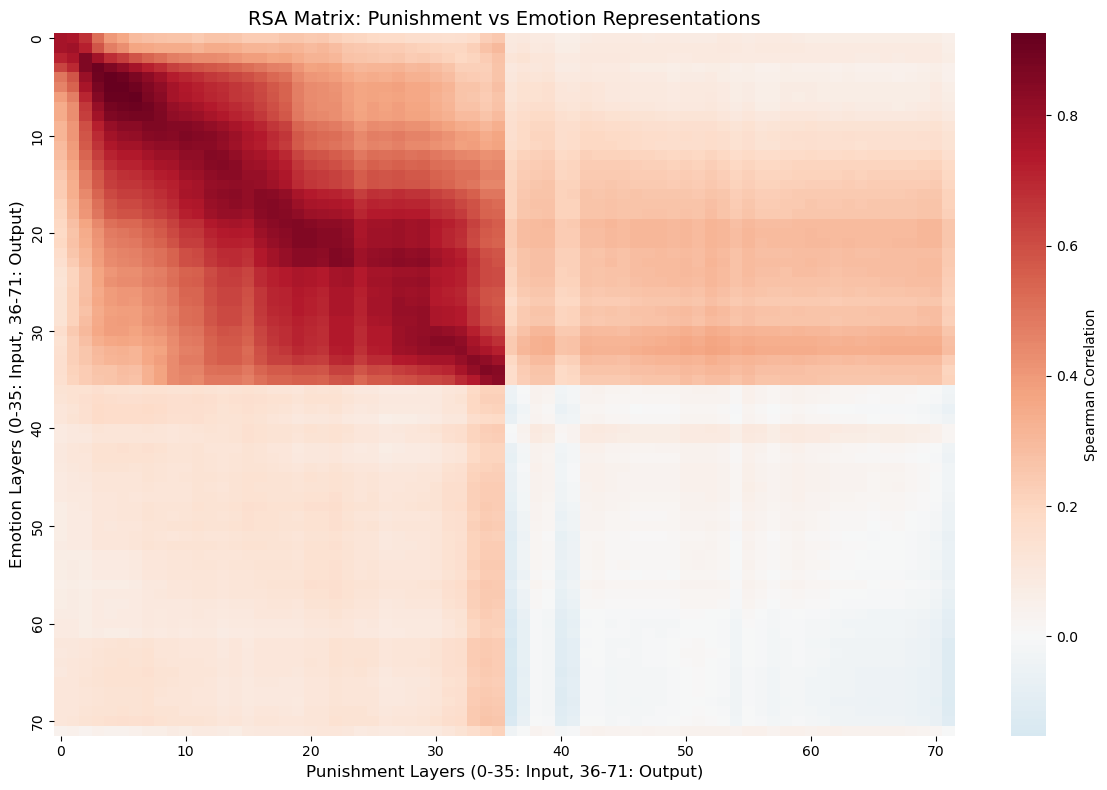


RSA矩阵统计信息:
平均RSA值: 0.2293
RSA值标准差: 0.2411

Input-Input block 平均RSA: 0.5766
Output-Output block 平均RSA: -0.0007
Input(Emotion)-Output(Punishment) block 平均RSA: 0.2132
Output(Emotion)-Input(Punishment) block 平均RSA: 0.1281

程序执行完毕!


In [5]:
# 代码2: compute_rsa_matrix.py - 使用保存的token信息计算RSA矩阵

import numpy as np
import os
import pickle
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# 文件夹路径
folder_path = "./llm_embedding/results/results"
token_info_file = 'score_token_info.pkl'

def load_file_data(file_path, token_index):
    """
    加载单个文件并提取相关数据
    返回: (input_last_hidden, output_hidden_at_score)
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        
        input_last_hidden = data['input_last_hidden']  # shape: (36, 4096)
        output_hidden = data['output_hidden']  # shape: (36, num_tokens, 4096)
        
        if token_index is not None and token_index < output_hidden.shape[1]:
            # 提取对应token的hidden states
            output_hidden_at_score = output_hidden[:, token_index, :]  # shape: (36, 4096)
            data.close()
            return input_last_hidden, output_hidden_at_score
        else:
            data.close()
            print(f"Warning: Invalid token index {token_index} for file {file_path}")
            return None, None
            
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None, None

def compute_rdm(hidden_states):
    """
    计算Representational Dissimilarity Matrix (RDM)
    使用余弦距离作为距离度量
    
    参数:
        hidden_states: shape (n_samples, n_features)
    返回:
        rdm: shape (n_samples, n_samples)
    """
    rdm = squareform(pdist(hidden_states, metric='cosine'))
    return rdm

def compute_rsa(rdm1, rdm2):
    """
    计算两个RDM之间的Representational Similarity Analysis (RSA)
    使用Spearman相关系数
    
    参数:
        rdm1: shape (n, n)
        rdm2: shape (m, m)
    返回:
        correlation: float
        p_value: float
    """
    rdm1_flat = rdm1.flatten()
    rdm2_flat = rdm2.flatten()
    
    correlation, p_value = spearmanr(rdm1_flat, rdm2_flat)
    return correlation, p_value

# ===================== 主程序 =====================

print("=" * 80)
print("加载token信息...")
print("=" * 80)

# 加载token信息
with open(token_info_file, 'rb') as f:
    all_token_info = pickle.load(f)

print(f"成功加载 {len(all_token_info)} 个文件的token信息")

print("\n" + "=" * 80)
print("开始加载数据并计算RSA矩阵...")
print("=" * 80)

# 存储所有配对的数据
all_pairs_data = []

for i in range(1, 217, 2):  # 只处理奇数（punishment）
    punishment_idx = i
    emotion_idx = i + 1
    
    punishment_file = f"prompt_{punishment_idx:03d}_punishment.npz"
    emotion_file = f"prompt_{emotion_idx:03d}_emotion.npz"
    
    # 检查token信息是否存在
    if punishment_file not in all_token_info or emotion_file not in all_token_info:
        print(f"跳过配对 {punishment_idx}/{emotion_idx}: token信息缺失")
        continue
    
    # 获取token索引
    p_token_idx = all_token_info[punishment_file]['token_index']
    e_token_idx = all_token_info[emotion_file]['token_index']
    
    if p_token_idx is None or e_token_idx is None:
        print(f"跳过配对 {punishment_idx}/{emotion_idx}: token索引无效")
        continue
    
    # 加载数据
    punishment_path = os.path.join(folder_path, punishment_file)
    emotion_path = os.path.join(folder_path, emotion_file)
    
    if os.path.exists(punishment_path) and os.path.exists(emotion_path):
        # 加载punishment数据
        p_input, p_output = load_file_data(punishment_path, p_token_idx)
        
        # 加载emotion数据
        e_input, e_output = load_file_data(emotion_path, e_token_idx)
        
        if p_input is not None and e_input is not None:
            all_pairs_data.append({
                'pair_id': i,
                'punishment_input': p_input,
                'punishment_output': p_output,
                'emotion_input': e_input,
                'emotion_output': e_output
            })
            
            if len(all_pairs_data) % 10 == 0:
                print(f"成功加载 {len(all_pairs_data)} 对数据...")

print(f"\n成功加载了 {len(all_pairs_data)} 对数据")

# 构建完整的表示矩阵
if len(all_pairs_data) > 0:
    punishment_representations = []
    emotion_representations = []
    
    for pair_data in all_pairs_data:
        # Punishment: concatenate input and output
        p_input = pair_data['punishment_input']  # (36, 4096)
        p_output = pair_data['punishment_output']  # (36, 4096)
        p_repr = np.concatenate([p_input, p_output], axis=0)  # (72, 4096)
        punishment_representations.append(p_repr)
        
        # Emotion: concatenate input and output
        e_input = pair_data['emotion_input']  # (36, 4096)
        e_output = pair_data['emotion_output']  # (36, 4096)
        e_repr = np.concatenate([e_input, e_output], axis=0)  # (72, 4096)
        emotion_representations.append(e_repr)
    
    # 转换为数组
    punishment_representations = np.array(punishment_representations)  # (n_pairs, 72, 4096)
    emotion_representations = np.array(emotion_representations)  # (n_pairs, 72, 4096)
    
    print(f"\nPunishment representations shape: {punishment_representations.shape}")
    print(f"Emotion representations shape: {emotion_representations.shape}")
    
    # 计算RSA矩阵
    n_layers = 72
    rsa_matrix = np.zeros((n_layers, n_layers))
    
    print("\n计算RSA矩阵...")
    for i in range(n_layers):
        for j in range(n_layers):
            # 对于punishment的第i层和emotion的第j层
            p_layer_i = punishment_representations[:, i, :]  # (n_pairs, 4096)
            e_layer_j = emotion_representations[:, j, :]  # (n_pairs, 4096)
            
            # 计算RDM
            rdm_p = compute_rdm(p_layer_i)  # (n_pairs, n_pairs)
            rdm_e = compute_rdm(e_layer_j)  # (n_pairs, n_pairs)
            
            # 计算RSA (Spearman correlation)
            correlation, _ = compute_rsa(rdm_p, rdm_e)
            rsa_matrix[i, j] = correlation
        
        if (i + 1) % 10 == 0:
            print(f"完成 {i + 1}/{n_layers} 层")
    
    print("\nRSA矩阵计算完成!")
    print(f"RSA矩阵形状: {rsa_matrix.shape}")
    print(f"RSA值范围: [{rsa_matrix.min():.4f}, {rsa_matrix.max():.4f}]")
    
    # 保存RSA矩阵
    np.save('rsa_matrix.npy', rsa_matrix)
    print("\nRSA矩阵已保存到 'rsa_matrix.npy'")
    
    # 可视化RSA矩阵
    plt.figure(figsize=(12, 8))
    sns.heatmap(rsa_matrix, cmap='RdBu_r', center=0, 
                xticklabels=10, yticklabels=10,
                cbar_kws={'label': 'Spearman Correlation'})
    plt.xlabel('Punishment Layers (0-35: Input, 36-71: Output)', fontsize=12)
    plt.ylabel('Emotion Layers (0-35: Input, 36-71: Output)', fontsize=12)
    plt.title('RSA Matrix: Punishment vs Emotion Representations', fontsize=14)
    plt.tight_layout()
    plt.savefig('rsa_matrix_heatmap.png', dpi=300, bbox_inches='tight')
    print("RSA矩阵热图已保存到 'rsa_matrix_heatmap.png'")
    plt.show()
    
    # 打印统计信息
    print("\n" + "=" * 80)
    print("RSA矩阵统计信息:")
    print("=" * 80)
    print(f"平均RSA值: {rsa_matrix.mean():.4f}")
    print(f"RSA值标准差: {rsa_matrix.std():.4f}")
    
    # Input-Input block (0:36, 0:36)
    input_input_block = rsa_matrix[:36, :36]
    print(f"\nInput-Input block 平均RSA: {input_input_block.mean():.4f}")
    
    # Output-Output block (36:72, 36:72)
    output_output_block = rsa_matrix[36:, 36:]
    print(f"Output-Output block 平均RSA: {output_output_block.mean():.4f}")
    
    # Input-Output cross blocks
    input_output_block = rsa_matrix[:36, 36:]
    output_input_block = rsa_matrix[36:, :36]
    print(f"Input(Emotion)-Output(Punishment) block 平均RSA: {input_output_block.mean():.4f}")
    print(f"Output(Emotion)-Input(Punishment) block 平均RSA: {output_input_block.mean():.4f}")
    
else:
    print("没有成功加载任何配对数据！")

print("\n" + "=" * 80)
print("程序执行完毕!")
print("=" * 80)